In [1]:
from imports import cv2, os, np, tf, ImageDataGenerator, plt, pd, requests
import confidential

firebase_url = confidential.get_url()

response = requests.get(firebase_url)

data = response.json()
data_list = [value for key, value in data.items()]

df = pd.DataFrame(data_list)
df = df[["name", "url"]]

def download_image(url, name):
    """
    Downloads the images from database

    Args:
        url: url of the image

    Returns:
        image: image in grayscale
    """
    response = requests.get(url)
    image_data = response.content
    array = bytearray(image_data)

    image = cv2.imdecode(np.asarray(array, dtype=np.uint8), cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (160, 160))
    return image

images = []

for index, row in df.iterrows():
    image = download_image(row["url"], row["name"])
    images.append(image)

images = np.array(images)

2024-04-04 20:08:12.978482: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 20:08:12.978526: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 20:08:12.979261: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-04 20:08:12.984388: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-04 20:08:13.669747: W tensorflow/compiler/tf2

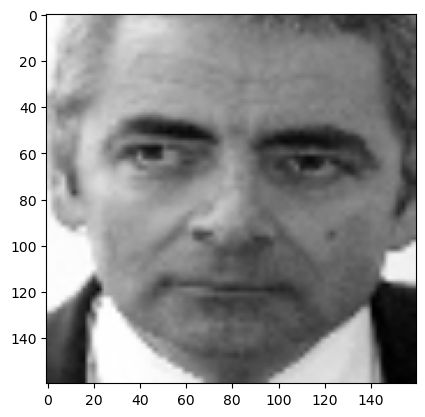

In [2]:
def crop_face(image):
    """
    Crops the face from input image using Haar Cascade Classifier

    Args:
        image: image

    Returns:
        face: face image
    """
    face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
    faces = face_cascade.detectMultiScale(image, 1.1, 4)
    if len(faces) == 0:
        return None
    for (x, y, w, h) in faces:
        face = cv2.resize(image[y:y+h, x:x+w], (160, 160))
    return face

faces = []

for image in images:
    face = crop_face(image)
    if face is not None:
        faces.append(face)

faces = np.array(faces)

plt.imshow(faces[0], cmap="gray")

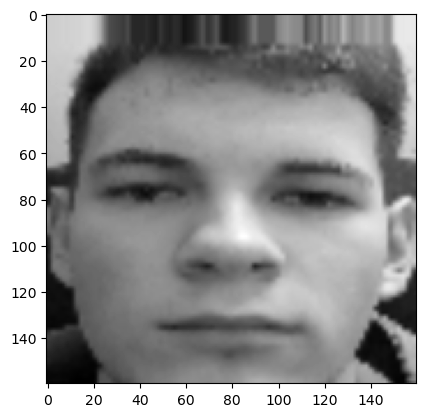

In [3]:
precision = 50

def augment_images(images):
    """
    Augment images using ImageDataGenerator

    Args:
        images (numpy.ndarray): Images to augment
    
    Returns:
        numpy.ndarray: Augmented images
    """
    train_datagen = ImageDataGenerator(rescale=1./255,
                                        rotation_range=40,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        vertical_flip=True,
                                        fill_mode='nearest'
                                        )
    augmented_images = []
    for image in images:
        image = np.expand_dims(image, 0)
        i = 0
        for i in range(precision):
            augmented_images.append(train_datagen.random_transform(image))
            i += 1
            if i >= precision:
                break
    return augmented_images

augmented_images = augment_images(faces)
augmented_images = np.array(augmented_images).reshape(-1, 160, 160)
plt.imshow(augmented_images[50], cmap='gray')

In [4]:
from sklearn.datasets import fetch_lfw_people

lfw_people = fetch_lfw_people(min_faces_per_person=50)
lfw_images = lfw_people.images
lwf_target_names = lfw_people.target_names
lwf_labels = lfw_people.target
lfw_images = [cv2.resize(image, (160, 160)) for image in lfw_images]
lfw_images = np.array(lfw_images)
lwf_labels = np.array(lwf_labels)
names = df["name"].values
labels = np.arange(len(names))
labels += len(lwf_target_names)
labels = np.repeat(labels, precision)
names = np.append(lwf_target_names, names)
labels = np.append(lwf_labels, labels)
images = np.append(lfw_images, augmented_images, axis=0)
classes = len(names)

In [5]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [6]:
def conv_block(input, filters, kernel_size, pool_size):
    """
    Convolutional block with Conv2D, Activation and MaxPooling2D layers
    """
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding="same", activation="elu")(input)
    x = tf.keras.layers.Activation("elu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size)(x)
    return x

def dense_block(input, units, dropout):
    """
    Dense block with Dense, Activation and Dropout layers
    """
    x = tf.keras.layers.Dense(units, activation="elu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(input)
    x = tf.keras.layers.Dropout(dropout)(x)
    return x

def build_model(input_shape, classes, num_conv_layers, num_dense_layers, num_dense_units, dropout_rate, filters, kernel_size, pool_size, learning_rate):
    """
    Build the model with the given parameters
    """
    input = tf.keras.layers.Input(shape=input_shape)
    x = conv_block(input, filters, kernel_size, pool_size)
    for i in range(num_conv_layers - 1):
        x = conv_block(x, filters, kernel_size, pool_size)
    x = tf.keras.layers.Flatten()(x)
    for i in range(num_dense_layers):
        x = dense_block(x, num_dense_units, dropout_rate)
    output = tf.keras.layers.Dense(classes, activation="softmax")(x)
    model = tf.keras.Model(inputs=input, outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

In [7]:
param_dist = {
    "learning_rate": [0.0005, 0.00065, 0.0008, 0.0009, 0.001, 0.005],
    "batch_size": [16, 24, 32, 48],
    "filters": [32, 64, 128],
}

from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier

model = KerasClassifier(build_fn=build_model, input_shape=(160, 160, 1), classes=classes, num_conv_layers=3, num_dense_layers=3, num_dense_units=512, dropout_rate=0.8, filters=128, kernel_size=(4, 4), pool_size=(4, 4), learning_rate = 0.001, epochs=40, verbose=1)

random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=3, cv=3, verbose=1)

random_search.fit(X_train, y_train)

print(random_search.best_params_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/home/lennart/.local/mambaforge/envs/ml/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
2024-04-04 20:08:17.910373: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-04 20:08:17.934239: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-04 20:08:17.934306: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-04 20:08:17.936655: I exte

Epoch 1/40


2024-04-04 20:08:19.211398: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-04 20:08:19.303841: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-04 20:08:19.515187: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-04 20:08:20.184672: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f9f353dbf30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-04 20:08:20.184712: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-04-04 20:08:20.189190: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1712254100.264640  121687 device_compiler.

59/59 [==============================] - 5s 24ms/step - loss: 17.9229 - accuracy: 0.1652
Epoch 2/40
59/59 [==============================] - 1s 13ms/step - loss: 13.9860 - accuracy: 0.2665
Epoch 3/40
59/59 [==============================] - 1s 14ms/step - loss: 12.8823 - accuracy: 0.2985
Epoch 4/40
59/59 [==============================] - 1s 15ms/step - loss: 12.2234 - accuracy: 0.2974
Epoch 5/40
59/59 [==============================] - 1s 13ms/step - loss: 11.3625 - accuracy: 0.2942
Epoch 6/40
59/59 [==============================] - 1s 13ms/step - loss: 10.7582 - accuracy: 0.3038
Epoch 7/40
59/59 [==============================] - 1s 13ms/step - loss: 10.0530 - accuracy: 0.3177
Epoch 8/40
59/59 [==============================] - 1s 13ms/step - loss: 9.5139 - accuracy: 0.3166
Epoch 9/40
59/59 [==============================] - 1s 13ms/step - loss: 8.8480 - accuracy: 0.3348
Epoch 10/40
59/59 [==============================] - 1s 13ms/step - loss: 8.2619 - accuracy: 0.3486
Epoch 11/40
5

/home/lennart/.local/mambaforge/envs/ml/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


59/59 [==============================] - 3s 23ms/step - loss: 19.6438 - accuracy: 0.1608
Epoch 2/40
59/59 [==============================] - 1s 13ms/step - loss: 14.3184 - accuracy: 0.2694
Epoch 3/40
59/59 [==============================] - 1s 13ms/step - loss: 13.2093 - accuracy: 0.2854
Epoch 4/40
59/59 [==============================] - 1s 13ms/step - loss: 12.3828 - accuracy: 0.3046
Epoch 5/40
59/59 [==============================] - 1s 13ms/step - loss: 11.6306 - accuracy: 0.3227
Epoch 6/40
59/59 [==============================] - 1s 13ms/step - loss: 10.9388 - accuracy: 0.3174
Epoch 7/40
59/59 [==============================] - 1s 13ms/step - loss: 10.2512 - accuracy: 0.3365
Epoch 8/40
59/59 [==============================] - 1s 13ms/step - loss: 9.7698 - accuracy: 0.3216
Epoch 9/40
59/59 [==============================] - 1s 13ms/step - loss: 9.1204 - accuracy: 0.3355
Epoch 10/40
59/59 [==============================] - 1s 13ms/step - loss: 8.5002 - accuracy: 0.3727
Epoch 11/40
5

/home/lennart/.local/mambaforge/envs/ml/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


59/59 [==============================] - 2s 13ms/step - loss: 17.4090 - accuracy: 0.1778
Epoch 2/40
59/59 [==============================] - 1s 13ms/step - loss: 13.8795 - accuracy: 0.2929
Epoch 3/40
59/59 [==============================] - 1s 13ms/step - loss: 12.8828 - accuracy: 0.2993
Epoch 4/40
59/59 [==============================] - 1s 13ms/step - loss: 12.1782 - accuracy: 0.3003
Epoch 5/40
59/59 [==============================] - 1s 13ms/step - loss: 11.4375 - accuracy: 0.3142
Epoch 6/40
59/59 [==============================] - 1s 13ms/step - loss: 10.7970 - accuracy: 0.2982
Epoch 7/40
59/59 [==============================] - 1s 13ms/step - loss: 10.0770 - accuracy: 0.3078
Epoch 8/40
59/59 [==============================] - 1s 13ms/step - loss: 9.4319 - accuracy: 0.3280
Epoch 9/40
59/59 [==============================] - 1s 13ms/step - loss: 8.8011 - accuracy: 0.3440
Epoch 10/40
59/59 [==============================] - 1s 13ms/step - loss: 8.2038 - accuracy: 0.3685
Epoch 11/40
5

/home/lennart/.local/mambaforge/envs/ml/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


30/30 [==============================] - 3s 32ms/step - loss: 18.2435 - accuracy: 0.1343
Epoch 2/40
30/30 [==============================] - 0s 13ms/step - loss: 13.5186 - accuracy: 0.2751
Epoch 3/40
30/30 [==============================] - 0s 13ms/step - loss: 12.7596 - accuracy: 0.2836
Epoch 4/40
30/30 [==============================] - 0s 13ms/step - loss: 12.0716 - accuracy: 0.3038
Epoch 5/40
30/30 [==============================] - 0s 13ms/step - loss: 11.3603 - accuracy: 0.3145
Epoch 6/40
30/30 [==============================] - 0s 13ms/step - loss: 10.7755 - accuracy: 0.3198
Epoch 7/40
30/30 [==============================] - 0s 13ms/step - loss: 10.2347 - accuracy: 0.3134
Epoch 8/40
30/30 [==============================] - 0s 13ms/step - loss: 9.7181 - accuracy: 0.3145
Epoch 9/40
30/30 [==============================] - 0s 13ms/step - loss: 9.2644 - accuracy: 0.3134
Epoch 10/40
30/30 [==============================] - 0s 13ms/step - loss: 8.7841 - accuracy: 0.3188
Epoch 11/40
3

/home/lennart/.local/mambaforge/envs/ml/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


30/30 [==============================] - 2s 31ms/step - loss: 16.8479 - accuracy: 0.1235
Epoch 2/40
30/30 [==============================] - 0s 13ms/step - loss: 13.4249 - accuracy: 0.2567
Epoch 3/40
30/30 [==============================] - 0s 13ms/step - loss: 12.4524 - accuracy: 0.3067
Epoch 4/40
30/30 [==============================] - 0s 13ms/step - loss: 11.7578 - accuracy: 0.3024
Epoch 5/40
30/30 [==============================] - 0s 13ms/step - loss: 11.0390 - accuracy: 0.2929
Epoch 6/40
30/30 [==============================] - 0s 13ms/step - loss: 10.4578 - accuracy: 0.2982
Epoch 7/40
30/30 [==============================] - 0s 13ms/step - loss: 9.8887 - accuracy: 0.3067
Epoch 8/40
30/30 [==============================] - 0s 13ms/step - loss: 9.3855 - accuracy: 0.3163
Epoch 9/40
30/30 [==============================] - 0s 13ms/step - loss: 8.8103 - accuracy: 0.3248
Epoch 10/40
30/30 [==============================] - 0s 13ms/step - loss: 8.3766 - accuracy: 0.3184
Epoch 11/40
30

/home/lennart/.local/mambaforge/envs/ml/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


30/30 [==============================] - 2s 13ms/step - loss: 16.6128 - accuracy: 0.1491
Epoch 2/40
30/30 [==============================] - 0s 13ms/step - loss: 13.3481 - accuracy: 0.2833
Epoch 3/40
30/30 [==============================] - 0s 13ms/step - loss: 12.4229 - accuracy: 0.3067
Epoch 4/40
30/30 [==============================] - 0s 13ms/step - loss: 11.7184 - accuracy: 0.3099
Epoch 5/40
30/30 [==============================] - 0s 13ms/step - loss: 11.1327 - accuracy: 0.3142
Epoch 6/40
30/30 [==============================] - 0s 13ms/step - loss: 10.5760 - accuracy: 0.3142
Epoch 7/40
30/30 [==============================] - 0s 13ms/step - loss: 9.9470 - accuracy: 0.3142
Epoch 8/40
30/30 [==============================] - 0s 13ms/step - loss: 9.4410 - accuracy: 0.3131
Epoch 9/40
30/30 [==============================] - 0s 13ms/step - loss: 8.9744 - accuracy: 0.3110
Epoch 10/40
30/30 [==============================] - 0s 13ms/step - loss: 8.5028 - accuracy: 0.3216
Epoch 11/40
30

/home/lennart/.local/mambaforge/envs/ml/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


30/30 [==============================] - 3s 20ms/step - loss: 18.4955 - accuracy: 0.1514
Epoch 2/40
30/30 [==============================] - 1s 20ms/step - loss: 14.9387 - accuracy: 0.2548
Epoch 3/40
30/30 [==============================] - 1s 20ms/step - loss: 13.9685 - accuracy: 0.2761
Epoch 4/40
30/30 [==============================] - 1s 20ms/step - loss: 13.2536 - accuracy: 0.2964
Epoch 5/40
30/30 [==============================] - 1s 20ms/step - loss: 12.5790 - accuracy: 0.3060
Epoch 6/40
30/30 [==============================] - 1s 20ms/step - loss: 11.9625 - accuracy: 0.3038
Epoch 7/40
30/30 [==============================] - 1s 20ms/step - loss: 11.4116 - accuracy: 0.3017
Epoch 8/40
30/30 [==============================] - 1s 20ms/step - loss: 10.8711 - accuracy: 0.3198
Epoch 9/40
30/30 [==============================] - 1s 20ms/step - loss: 10.2742 - accuracy: 0.3284
Epoch 10/40
30/30 [==============================] - 1s 20ms/step - loss: 9.7534 - accuracy: 0.3326
Epoch 11/40

/home/lennart/.local/mambaforge/envs/ml/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


30/30 [==============================] - 2s 20ms/step - loss: 19.7186 - accuracy: 0.1182
Epoch 2/40
30/30 [==============================] - 1s 20ms/step - loss: 15.3029 - accuracy: 0.2630
Epoch 3/40
30/30 [==============================] - 1s 20ms/step - loss: 14.4719 - accuracy: 0.2769
Epoch 4/40
30/30 [==============================] - 1s 20ms/step - loss: 13.7153 - accuracy: 0.2982
Epoch 5/40
30/30 [==============================] - 1s 20ms/step - loss: 13.1332 - accuracy: 0.3088
Epoch 6/40
30/30 [==============================] - 1s 20ms/step - loss: 12.7225 - accuracy: 0.2875
Epoch 7/40
30/30 [==============================] - 1s 20ms/step - loss: 12.1433 - accuracy: 0.3110
Epoch 8/40
30/30 [==============================] - 1s 20ms/step - loss: 11.6324 - accuracy: 0.3067
Epoch 9/40
30/30 [==============================] - 1s 20ms/step - loss: 11.1510 - accuracy: 0.3088
Epoch 10/40
30/30 [==============================] - 1s 20ms/step - loss: 10.7017 - accuracy: 0.3237
Epoch 11/4

/home/lennart/.local/mambaforge/envs/ml/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


30/30 [==============================] - 2s 20ms/step - loss: 18.6612 - accuracy: 0.1395
Epoch 2/40
30/30 [==============================] - 1s 20ms/step - loss: 14.9762 - accuracy: 0.2503
Epoch 3/40
30/30 [==============================] - 1s 20ms/step - loss: 13.9661 - accuracy: 0.3003
Epoch 4/40
30/30 [==============================] - 1s 20ms/step - loss: 13.2834 - accuracy: 0.3046
Epoch 5/40
30/30 [==============================] - 1s 20ms/step - loss: 12.6242 - accuracy: 0.3067
Epoch 6/40
30/30 [==============================] - 1s 20ms/step - loss: 12.0339 - accuracy: 0.3120
Epoch 7/40
30/30 [==============================] - 1s 20ms/step - loss: 11.4712 - accuracy: 0.3195
Epoch 8/40
30/30 [==============================] - 1s 20ms/step - loss: 10.9156 - accuracy: 0.3355
Epoch 9/40
30/30 [==============================] - 1s 20ms/step - loss: 10.3837 - accuracy: 0.3269
Epoch 10/40
30/30 [==============================] - 1s 20ms/step - loss: 9.8482 - accuracy: 0.3365
Epoch 11/40

/home/lennart/.local/mambaforge/envs/ml/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/40
88/88 [==============================] - 2s 12ms/step - loss: 16.5968 - accuracy: 0.1925
Epoch 2/40
88/88 [==============================] - 1s 11ms/step - loss: 13.1389 - accuracy: 0.2962
Epoch 3/40
88/88 [==============================] - 1s 11ms/step - loss: 11.9751 - accuracy: 0.3011
Epoch 4/40
88/88 [==============================] - 1s 11ms/step - loss: 10.8857 - accuracy: 0.3196
Epoch 5/40
88/88 [==============================] - 1s 11ms/step - loss: 9.8874 - accuracy: 0.3232
Epoch 6/40
88/88 [==============================] - 1s 11ms/step - loss: 8.9536 - accuracy: 0.3395
Epoch 7/40
88/88 [==============================] - 1s 11ms/step - loss: 8.0983 - accuracy: 0.3778
Epoch 8/40
88/88 [==============================] - 1s 11ms/step - loss: 7.3240 - accuracy: 0.4084
Epoch 9/40
88/88 [==============================] - 1s 11ms/step - loss: 6.6795 - accuracy: 0.4283
Epoch 10/40
88/88 [==============================] - 1s 11ms/step - loss: 6.0957 - accuracy: 0.4517
Epoch